In [47]:
import pandas as pd
import numpy as np
from ggplot import *
% matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# Define Mortgage Details: 

In [48]:
# Calculates monthly payment given number of months(n), loan amount(L), and the monthly interest rate (APY/12)
def calculate_montly_payment(n,L,monthly_interest):
    I = monthly_interest
    numerator = L*(1 + I)**n
    denomenator = -1*(1 - (1 + I)**n) / I
    return (numerator/denomenator)

In [49]:
# Mortgage
time = 30 # number of years for mortgage
interest = .04 # APY interest rate
price = 600000 # dollars
down_payment = .2 # percent/100
yearly_house_appreciation = .02 # percent appreciation of house value

# Taxes
marginal_tax_rate = .28 
#expected_deduction = 6400 # expected standard deduction for current year
#expected_deduction_yearly_increase = 100 # expected increase in standard deduction each year
expected_deduction = 0 # expected standard deduction for current year
expected_deduction_yearly_increase = 0 # expected increase in standard deduction each year
property_tax = .01 # percent of house value payed as yearly property tax
long_term_capital_gains = .15

# Extra Costs
yearly_maintenance = .001 # percent of house value set aside yearly for repairs and maintenance
hoa_fee = 300 # montly hoa fee
hoa_yearly_increase = .01 # yearly percent increase in hoa fee
homeowner_insurance = 30 # monthly payment for insurance
homeowner_yearly_increase = .01 # yearly percent increase in insurance
closing_buy = .06 # percent of house value for closing cost when buying
closing_sell = .06 # percent of house value for closing cost when selling

#Rental Income
monthly_rent = 3000 # expected monthly rent for current year
rent_yearly_increase = .02 # yearly percent increase in rent
percent_vacancy = .1 #1.0/12.0 # percent of the year with vacancy
rent_percent = 1.0 #percent of monthly rent as income, 0 means not renting, 1 means rental property

# Oportunity costs
investment_return = .06 #average yearly return
opportunity_rent = monthly_rent * (1 - rent_percent)

In [50]:
# For calculations: do not edit
n = time * 12 #number of months for the loan
L = price * (1.0 - down_payment) # loan amount
monthly_interest = interest/12.0 # monthly interest rate as a percent/100
p = calculate_montly_payment(n,L,monthly_interest) # monthly payment
print 'Monthly Payment = %.2f'%p

Monthly Payment = 2291.59


Key Assumptions:  
1. No capital gains when you sell your house (google for details)
2. House Value, HOA, Maintenance, Insurance, and Rent all increase/decrease by the same amount each year. Not a problem for long-term if good estimates.
3. You stick with one rental strategy.
4. Fixed Rate
5. No PMI
6. All gains on stocks are long term capital gains

# Calculate Cumulative Equity and Interest per month: 

In [51]:
mortgage = pd.DataFrame()
loan = L
month_list = range(1,n+1)
for month in month_list: # simulate monthly payment
    mortgage_month = pd.DataFrame()
    mortgage_month['Month'] = [month]
    mortgage_month['Loan_Before_Payment'] = loan
    loan = loan * (1+ monthly_interest) - p
    mortgage_month['Loan_After_Payment'] = loan
    mortgage_month['Equity_Gain'] = mortgage_month['Loan_Before_Payment'] - mortgage_month['Loan_After_Payment']
    mortgage = pd.concat([mortgage,mortgage_month])
mortgage['Interest_Paid'] = p - mortgage['Equity_Gain']
mortgage['Tax_Savings'] = mortgage['Interest_Paid'] * marginal_tax_rate
mortgage['Cumulative_Tax_Savings'] = mortgage['Tax_Savings'].cumsum()
mortgage['Year'] = np.ceil(mortgage['Month']/12.0)
mortgage['Cumulative_Equity_Gain'] = mortgage['Equity_Gain'].cumsum()
mortgage['Cumulative_Interest_Paid'] = mortgage['Interest_Paid'].cumsum()
mortgage['Total_Equity_With_Appreciation'] = (mortgage['Cumulative_Equity_Gain'] + down_payment * price) * (1 + yearly_house_appreciation)**mortgage['Year']
mortgage.set_index([range(len(mortgage))], inplace = True)

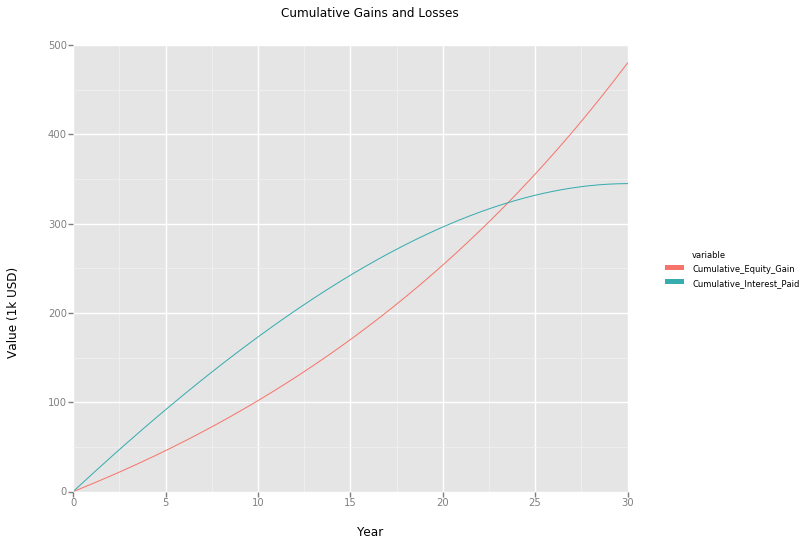

<ggplot: (17460502)>

In [52]:
plot_data = pd.melt(mortgage[['Month','Cumulative_Equity_Gain','Cumulative_Interest_Paid']], id_vars = ['Month'], value_vars = ['Cumulative_Equity_Gain','Cumulative_Interest_Paid'])
ggplot(aes(x = 'Month/12.0', y = 'value/1000', color = 'variable'), data = plot_data)\
+ geom_line()\
+ xlab('Year')\
+ ylab('Value (1k USD)')\
+ ggtitle('Cumulative Gains and Losses')\
 

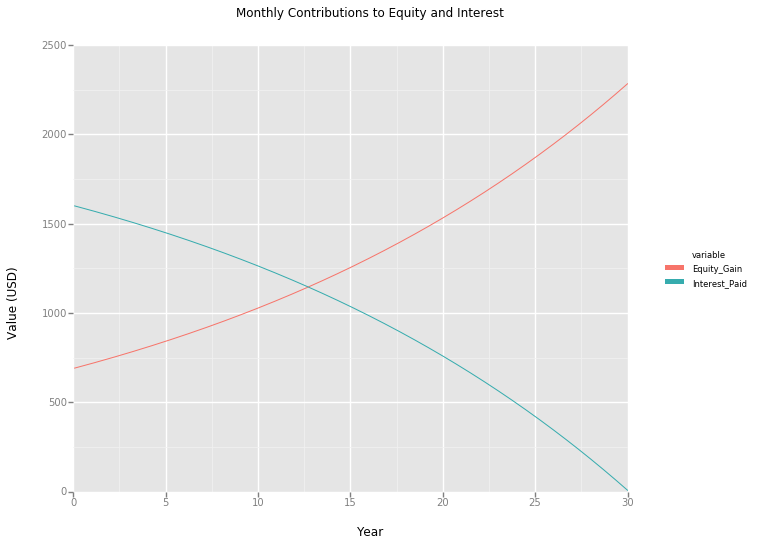

<ggplot: (18262350)>

In [53]:
plot_data_monthly = pd.melt(mortgage[['Month','Equity_Gain','Interest_Paid']], id_vars = ['Month'], value_vars = ['Equity_Gain','Interest_Paid'])
ggplot(aes(x = 'Month/12.0', y = 'value', color = 'variable'), data = plot_data_monthly)\
+ geom_line()\
+ geom_hline(yintercept = [np.round(p)], color = 'black')\
+ xlab('Year')\
+ ylab('Value (USD)')\
+ ggtitle('Monthly Contributions to Equity and Interest')
 

# Yearly Info:

In [54]:
yearly_mortgage = mortgage[mortgage.Month%12 == 0] # Gives end of the year
yearly_mortgage = yearly_mortgage[['Year','Cumulative_Interest_Paid','Total_Equity_With_Appreciation','Cumulative_Tax_Savings']]

# House Appreciation
yearly_mortgage['House_Value'] = price * (1 + yearly_house_appreciation)**yearly_mortgage['Year']

# Taxes
yearly_mortgage['Property_Tax'] = property_tax * yearly_mortgage['House_Value']
yearly_mortgage['Cumulative_Property_Tax'] = yearly_mortgage['Property_Tax'].cumsum()
yearly_mortgage['Tax_Savings'] = yearly_mortgage['Cumulative_Tax_Savings'] 
yearly_mortgage['Tax_Savings'].iloc[1:len(yearly_mortgage)] = np.diff(yearly_mortgage['Cumulative_Tax_Savings']) #so far only from interest
yearly_mortgage['Tax_Savings'] += marginal_tax_rate * yearly_mortgage['Property_Tax'] # property tax also deductable
yearly_mortgage['Expected_Tax_Savings'] = (expected_deduction + expected_deduction_yearly_increase * mortgage['Year']) * (marginal_tax_rate) # Tax savings from standard dedecution
yearly_mortgage['Effective_Tax_Savings'] = yearly_mortgage['Tax_Savings'] - yearly_mortgage['Expected_Tax_Savings'] # Only count if savings above what you would get from standard deduction
yearly_mortgage['Effective_Tax_Savings'] = yearly_mortgage['Effective_Tax_Savings'].apply(lambda x: x if x > 0 else 0)
yearly_mortgage['Cumulative_Tax_Savings'] = yearly_mortgage['Effective_Tax_Savings'].cumsum()

# Total Costs
yearly_mortgage['HOA'] = 12 * hoa_fee * ((1 + hoa_yearly_increase) ** yearly_mortgage['Year'])
yearly_mortgage['Cumulative_HOA'] = yearly_mortgage['HOA'].cumsum()
yearly_mortgage['Homeowner_Insurance'] = 12 *homeowner_insurance * ((1 + homeowner_yearly_increase) ** yearly_mortgage['Year'])
yearly_mortgage['Cumulative_Homeowner_Insurance'] = yearly_mortgage['Homeowner_Insurance'].cumsum()
yearly_mortgage['Maintenance'] = yearly_maintenance * yearly_mortgage['House_Value']
yearly_mortgage['Cumulative_Maintenance'] = yearly_mortgage['Maintenance'].cumsum()
yearly_mortgage['Total_Cost'] = yearly_mortgage['Cumulative_Property_Tax'] \
+ yearly_mortgage['Cumulative_Interest_Paid']\
+ yearly_mortgage['Cumulative_HOA']\
+ yearly_mortgage['Cumulative_Homeowner_Insurance']\
+ yearly_mortgage['Cumulative_Maintenance']\
+ price * closing_buy\
+ yearly_mortgage['House_Value'] * closing_sell\


# Rental income
yearly_mortgage['Rent_Income'] = ((1-marginal_tax_rate) * (1 - percent_vacancy) * 12 * monthly_rent * rent_percent ) * ((1 + rent_yearly_increase) ** yearly_mortgage['Year']) # taxed as income
yearly_mortgage['Cumulative_Rent_Income'] = yearly_mortgage['Rent_Income'].cumsum()

# Summary
yearly_mortgage['Effective_Cost'] = yearly_mortgage['Total_Cost'] - yearly_mortgage['Cumulative_Rent_Income'] - yearly_mortgage['Cumulative_Tax_Savings']
yearly_mortgage['House_Net_Value'] = yearly_mortgage['Total_Equity_With_Appreciation'] - yearly_mortgage['Effective_Cost']

#Opportunity Cost
#yearly_mortgage['Effective_Yearly_Cost'] = yearly_mortgage['Effective_Cost'] - price * closing_buy - yearly_mortgage['House_Value'] * closing_sell #these are the recurring costs that could otherwise be invested
#yearly_mortgage['Effective_Yearly_Cost'].iloc[1:len(yearly_mortgage)] = np.diff(yearly_mortgage['Effective_Yearly_Cost'])

yearly_mortgage['Initial_Opportunity'] = ((down_payment+closing_buy)*price) * (1 + investment_return)**(yearly_mortgage['Year']) * (1-long_term_capital_gains) # investing the downpayment and the closing cost of buying
yearly_mortgage['Yearly_Rent_Cost'] = 12 * opportunity_rent * ((1 + rent_yearly_increase) ** yearly_mortgage['Year']) # The cost of renting
if rent_percent == 1:
    yearly_mortgage['Yearly_Rent_Cost'] = 0
    

# Leftover money to invest if you choose to rent instead of buy, can be negative which means renting has opportunity cost
yearly_mortgage['Extra_Investing_Money'] = p * 12\
+ yearly_mortgage['HOA']\
+ yearly_mortgage['Property_Tax']\
+ yearly_mortgage['Homeowner_Insurance']\
+ yearly_mortgage['Maintenance']\
- yearly_mortgage['Rent_Income']\
- yearly_mortgage['Effective_Tax_Savings']\
- yearly_mortgage['Yearly_Rent_Cost']

#yearly_mortgage['Extra_Investing_Money'] = yearly_mortgage['Effective_Yearly_Cost'] - yearly_mortgage['Yearly_Rent_Cost'] # Leftover money to invest if you choose to rent instead of buy, it's fine if it is negative which means renting is costing you more


yearly_growth = np.array([])
for year in range(1,1 + time): #Take the extra investing money each year and invest it
    growth_years = yearly_mortgage[yearly_mortgage.Year <= year][['Year','Extra_Investing_Money']]
    growth_years['Years_Investing'] = np.array(growth_years.Year)[::-1] - 1 # The extra money is what you have at the end of the year, so at year 3, you would have invested the year 1 money for 2 years
    growth_years['Growth'] = growth_years['Extra_Investing_Money'] * (1 + investment_return) ** growth_years['Years_Investing']
    yearly_growth = np.append(yearly_growth,np.array([growth_years.Growth.sum()]))
    
yearly_mortgage['Total_Investment'] = yearly_growth * (1 - long_term_capital_gains)
yearly_mortgage['Rent_Net_Value'] = yearly_mortgage['Initial_Opportunity'] + yearly_mortgage['Total_Investment']
yearly_mortgage['Opportunity_Cost'] = yearly_mortgage['Rent_Net_Value'] - yearly_mortgage['House_Net_Value']

display_list = ['Year','Property_Tax','Effective_Tax_Savings','HOA','Homeowner_Insurance','Maintenance','Rent_Income','Extra_Investing_Money','Rent_Net_Value','Total_Equity_With_Appreciation','House_Net_Value']
yearly_mortgage[display_list]    

,Year,Property_Tax,Effective_Tax_Savings,HOA,Homeowner_Insurance,Maintenance,Rent_Income,Extra_Investing_Money,Rent_Net_Value,Total_Equity_With_Appreciation,House_Net_Value
11,1.0,6120.000000,7046.520919,3636.000000,363.600000,612.000000,23794.560000,7389.640100,1.468372e+05,1.310220e+05,5.936537e+04
23,2.0,6242.400000,6984.364492,3672.360000,367.236000,624.240000,24270.451200,7150.541327,1.617254e+05,1.427953e+05,7.205101e+04
35,3.0,6367.248000,6918.964862,3709.083600,370.908360,636.724800,24755.860224,6908.260692,1.773009e+05,1.553673e+05,8.612153e+04
47,4.0,6494.592960,6850.175679,3746.174436,374.617444,649.459296,25250.977428,6662.812046,1.936024e+05,1.687890e+05,1.016451e+05
59,5.0,6624.484819,6777.844347,3783.636180,378.363618,662.448482,25755.996977,6414.212795,2.106706e+05,1.831139e+05,1.186935e+05
71,6.0,6756.974516,6701.811759,3821.472542,382.147254,675.697452,26271.116917,6162.484106,2.285489e+05,1.983994e+05,1.373426e+05
83,7.0,6892.114006,6621.912036,3859.687268,385.968727,689.211401,26796.539255,5907.651129,2.472834e+05,2.147061e+05,1.576723e+05
95,8.0,7029.956286,6537.972234,3898.284140,389.828414,702.995629,27332.470040,5649.743214,2.669227e+05,2.320984e+05,1.797670e+05
107,9.0,7170.555412,6449.812058,3937.266982,393.726698,717.055541,27879.119441,5388.794153,2.875185e+05,2.506448e+05,2.037157e+05
119,10.0,7313.966520,6357.243552,3976.639651,397.663965,731.396652,28436.701830,5124.842426,3.091257e+05,2.704181e+05,2.296123e+05


In [56]:
yearly_mortgage.to_csv('test.csv')

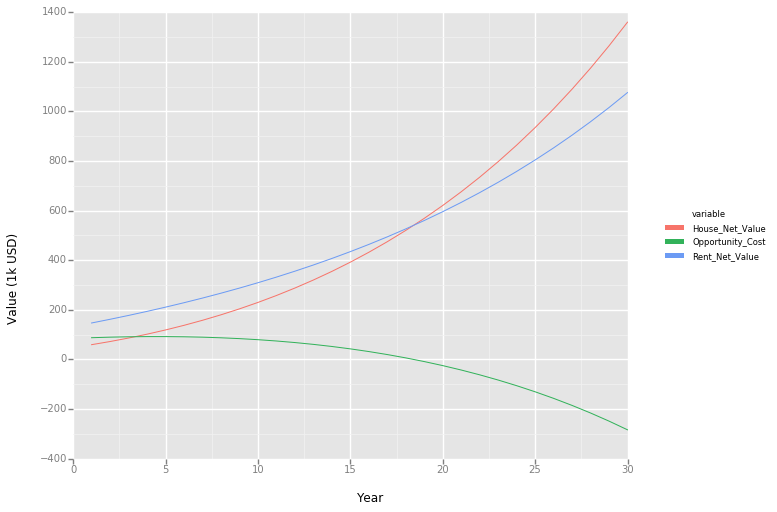

<ggplot: (18399808)>

In [55]:
total_plot = pd.melt(yearly_mortgage[['Year','House_Net_Value','Rent_Net_Value','Opportunity_Cost']], id_vars = ['Year'], value_vars = ['Opportunity_Cost','House_Net_Value','Rent_Net_Value'])
total_plot.set_index([range(len(total_plot))], inplace = True)
total_plot['value'] = np.round(total_plot['value'])
ggplot(aes(x = 'Year', y = 'value/1000', color = 'variable'), data = total_plot)\
+ geom_line()\
+ ylab('Value (1k USD)')
#+ xlim(0,10)
 

**House_Net_Value**: This is the amount of money in your pocket after you live there for x years and sell it on year x.  
**Rent_Net_Value**: This is the amount of money you have after x years if you rent instead and invest your initial cost (downpayment and closing). You invest the lefover money you have saved from renting.